# 0. Import Libraries

In [1]:
import sys
PARENT_PATH = '..'
sys.path.append(PARENT_PATH)
sys.path.append(PARENT_PATH + '/geopredictors')

import lasio
from geopredictors.prediction_tool import permeability_predictor as pp

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
#from geopredictors.facie_predictor.predictor import FaciesPredictor

# from facies_prediction import FaciesPredictor
# from facies_prediction.model import CustomResNet

# 1. Lithofacies Prediction

In [2]:
# predictor2 = FaciesPredictor()

# predictor2.model.load_state_dict(torch.load(f'{PARENT_PATH}/Sources/facies_model.pth'))

# image_path = f'{PARENT_PATH}/Sources/facies_features/204-20-3_image.npy'
# depth_path = f'{PARENT_PATH}/Sources/facies_features/204-20-3_depth.npy'

# ## Use it to predict facies. For demonstration purposes, we will use saved result of the predict.
# result = predictor2.predict(image_path,depth_path)

# 1.1 For Demonstration Purposes Only. Show saved facies result.

In [3]:
facies_df = pd.read_csv(f'{PARENT_PATH}/Sources/facies_prediction.csv')
facies_df

,Start Depth,End Depth,Predicted Class
0,1812.05,1812.35,is
1,1812.35,1812.50,is
2,1812.50,1812.72,is
3,1812.72,1813.05,is
4,1813.05,1813.30,nc
...,...,...,...
101,1837.25,1837.50,sh
102,1837.50,1837.75,sh
103,1837.75,1838.00,sh
104,1838.00,1838.20,sh


# 2. Permeability Prediction

## 2.1 Preprocess Data

In [4]:
# Get las data
well = lasio.read(f'{PARENT_PATH}/Sources/blinded_well/205-21b-3_logs.las') # Dont forget to change the path. The las file is too big and cannot be uploaded to github.
well_df_las = well.df()
well_df_las.index.name = 'Depth'
well_df_las

,AT10,AT20,AT30,AT60,AT90,CALI,DENC,DENS,DTC,DTS_1,DTS_2,GR,NEUT,PEF,SP,RDEP
Depth,,,,,,,,,,,,,,,,
300.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.8125,0.9029
300.1524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.2500,0.9748
300.3048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.2500,1.0102
300.4572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.3750,1.0369
300.6096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.8125,1.0558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299.3356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.1875,2.7990
2299.4880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.3750,2.9237
2299.6404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.0000,2.9004


In [5]:
well_poro_csv = pd.read_csv(f'{PARENT_PATH}/Sources/blinded_well/porosity.csv')
well_poro_csv

,DEPTH\n,POROSITY\n
0,1812.05,23.1
1,1812.35,24.4
2,1812.50,21.9
3,1812.72,21.3
4,1813.05,21.8
...,...,...
101,1837.25,31.6
102,1837.50,NaN
103,1837.75,NaN
104,1838.00,NaN


In [6]:
res = pp.preprocessing_data(well_df_las, well_poro_csv)
res

,DEPTH\n,POROSITY\n(HELIUM),true depth,AT10,AT20,AT30,AT60,AT90,CALI,DENC,DENS,DTC,DTS_1,DTS_2,GR,NEUT,PEF,SP,RDEP
0,1812.05,23.1,1812.1128,30.0065,36.7240,35.2649,23.4317,23.9072,12.1180,-0.0042,2.1037,114.4911,216.7765,241.5543,40.0711,0.3366,3.8203,107.0000,1.2496
1,1812.35,24.4,1812.4176,10.9299,11.0440,11.5311,13.7229,13.2441,12.3622,-0.0022,2.1415,113.9048,222.1246,237.9863,43.5429,0.3811,3.6572,107.6250,1.2905
2,1812.50,21.9,1812.5700,9.0866,8.9859,9.4058,10.9573,10.7390,12.3830,-0.0002,2.1711,113.7173,218.2412,236.8431,50.7017,0.3929,3.7000,106.8750,1.4469
3,1812.72,21.3,1812.7224,6.2646,5.9241,6.0360,5.5879,5.5494,12.3879,-0.0057,2.2011,113.7887,220.1747,236.6402,51.8244,0.4008,3.6377,107.0000,1.4748
4,1813.05,21.8,1813.0272,7.8119,7.3458,7.6149,7.6094,7.5039,12.4271,-0.0078,2.1960,114.4107,216.1605,234.1567,48.0420,0.3812,3.2011,106.9375,1.3945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,1837.25,31.6,1837.2588,37.4438,38.6034,43.8733,47.2475,48.4904,12.0679,-0.0073,2.1114,116.4732,206.2843,217.7892,37.6997,0.3564,3.2533,89.2500,1.3007
102,1837.50,NaN,1837.5636,58.3658,59.5739,60.8408,54.5201,54.7797,12.0581,-0.0022,2.1097,117.1042,213.2358,215.0510,35.8352,0.3383,2.9517,88.5625,1.2904
103,1837.75,NaN,1837.7160,73.4343,74.0699,75.5061,73.1261,72.6707,12.0398,-0.0006,2.0893,117.3423,215.3425,215.1421,36.8942,0.3306,2.8916,88.1250,1.5669
104,1838.00,NaN,1838.0208,54.3135,45.6871,48.9620,50.8813,50.8690,12.0398,-0.0044,2.0796,115.4881,221.7386,224.1987,39.3583,0.3500,3.0946,86.9375,1.6578


In [7]:
# # Ensure DataFrames are sorted by the key
# df1 = well_df_las.sort_values(by='Depth')
# df2 = well_poro_csv.sort_values(by='Depth')

# # Merge using merge_asof
# merged_df = pd.merge_asof(df1, df2, on='Depth', direction='nearest', tolerance=0.2)
# merged_df.set_index('Depth', inplace=True)
# df_interest = merged_df
# df_interest.reset_index(inplace=True)
# df_interest

In [8]:
# Select the features columns. It has to be the following: ['true depth', 'DENS', 'DTC', 'GR', 'NEUT', 'PEF', 'RSHAL', 'POROSITY\n(HELIUM)']
df_interest = res.copy()
df_interest_features = df_interest[['DEPTH\n','DENS', 'DTC', 'GR', 'NEUT', 'PEF', 'AT20', 'POROSITY\n(HELIUM)']]
df_interest_features.columns = ['true depth', 'DENS', 'DTC', 'GR', 'NEUT', 'PEF', 'RSHAL', 'POROSITY\n(HELIUM)']
# df_interest_features[(df_interest_features['true depth'] >= 1812) & (df_interest_features['true depth'] <= 1838.3)]
df_interest_features

,true depth,DENS,DTC,GR,NEUT,PEF,RSHAL,POROSITY\n(HELIUM)
0,1812.05,2.1037,114.4911,40.0711,0.3366,3.8203,36.7240,23.1
1,1812.35,2.1415,113.9048,43.5429,0.3811,3.6572,11.0440,24.4
2,1812.50,2.1711,113.7173,50.7017,0.3929,3.7000,8.9859,21.9
3,1812.72,2.2011,113.7887,51.8244,0.4008,3.6377,5.9241,21.3
4,1813.05,2.1960,114.4107,48.0420,0.3812,3.2011,7.3458,21.8
...,...,...,...,...,...,...,...,...
101,1837.25,2.1114,116.4732,37.6997,0.3564,3.2533,38.6034,31.6
102,1837.50,2.1097,117.1042,35.8352,0.3383,2.9517,59.5739,NaN
103,1837.75,2.0893,117.3423,36.8942,0.3306,2.8916,74.0699,NaN
104,1838.00,2.0796,115.4881,39.3583,0.3500,3.0946,45.6871,NaN


## 2.2 Predict Permeability

In [9]:
# Instantiate the predictor
pp_model            = pp.permeability_predict(folder_path=f'{PARENT_PATH}/Sources/preprocessed_log')
perm_predict_series = pp_model.predict('../Sources/blinded_well/205-21b-3_logs.las', '../Sources/blinded_well/porosity.csv')  # Get Prediction
perm_predict_df     = pd.DataFrame(perm_predict_series, columns=['Permeability'])
perm_predict_df


,Permeability
0,94.367305
1,94.367305
2,94.367305
3,90.880136
4,95.197730
...,...
101,999.514325
102,142.280201
103,144.923983
104,138.236287


# 3. Visualize Data

In [ ]:
# Merge all of the dataframes
visual_df = df_interest_features
visual_df['Permeability']   = perm_predict_df['Permeability'].to_list()
visual_df['Facies']         = [np.nan for i in range(len(visual_df['Permeability']))]   # The values in the list are non-relevant to the plotting.

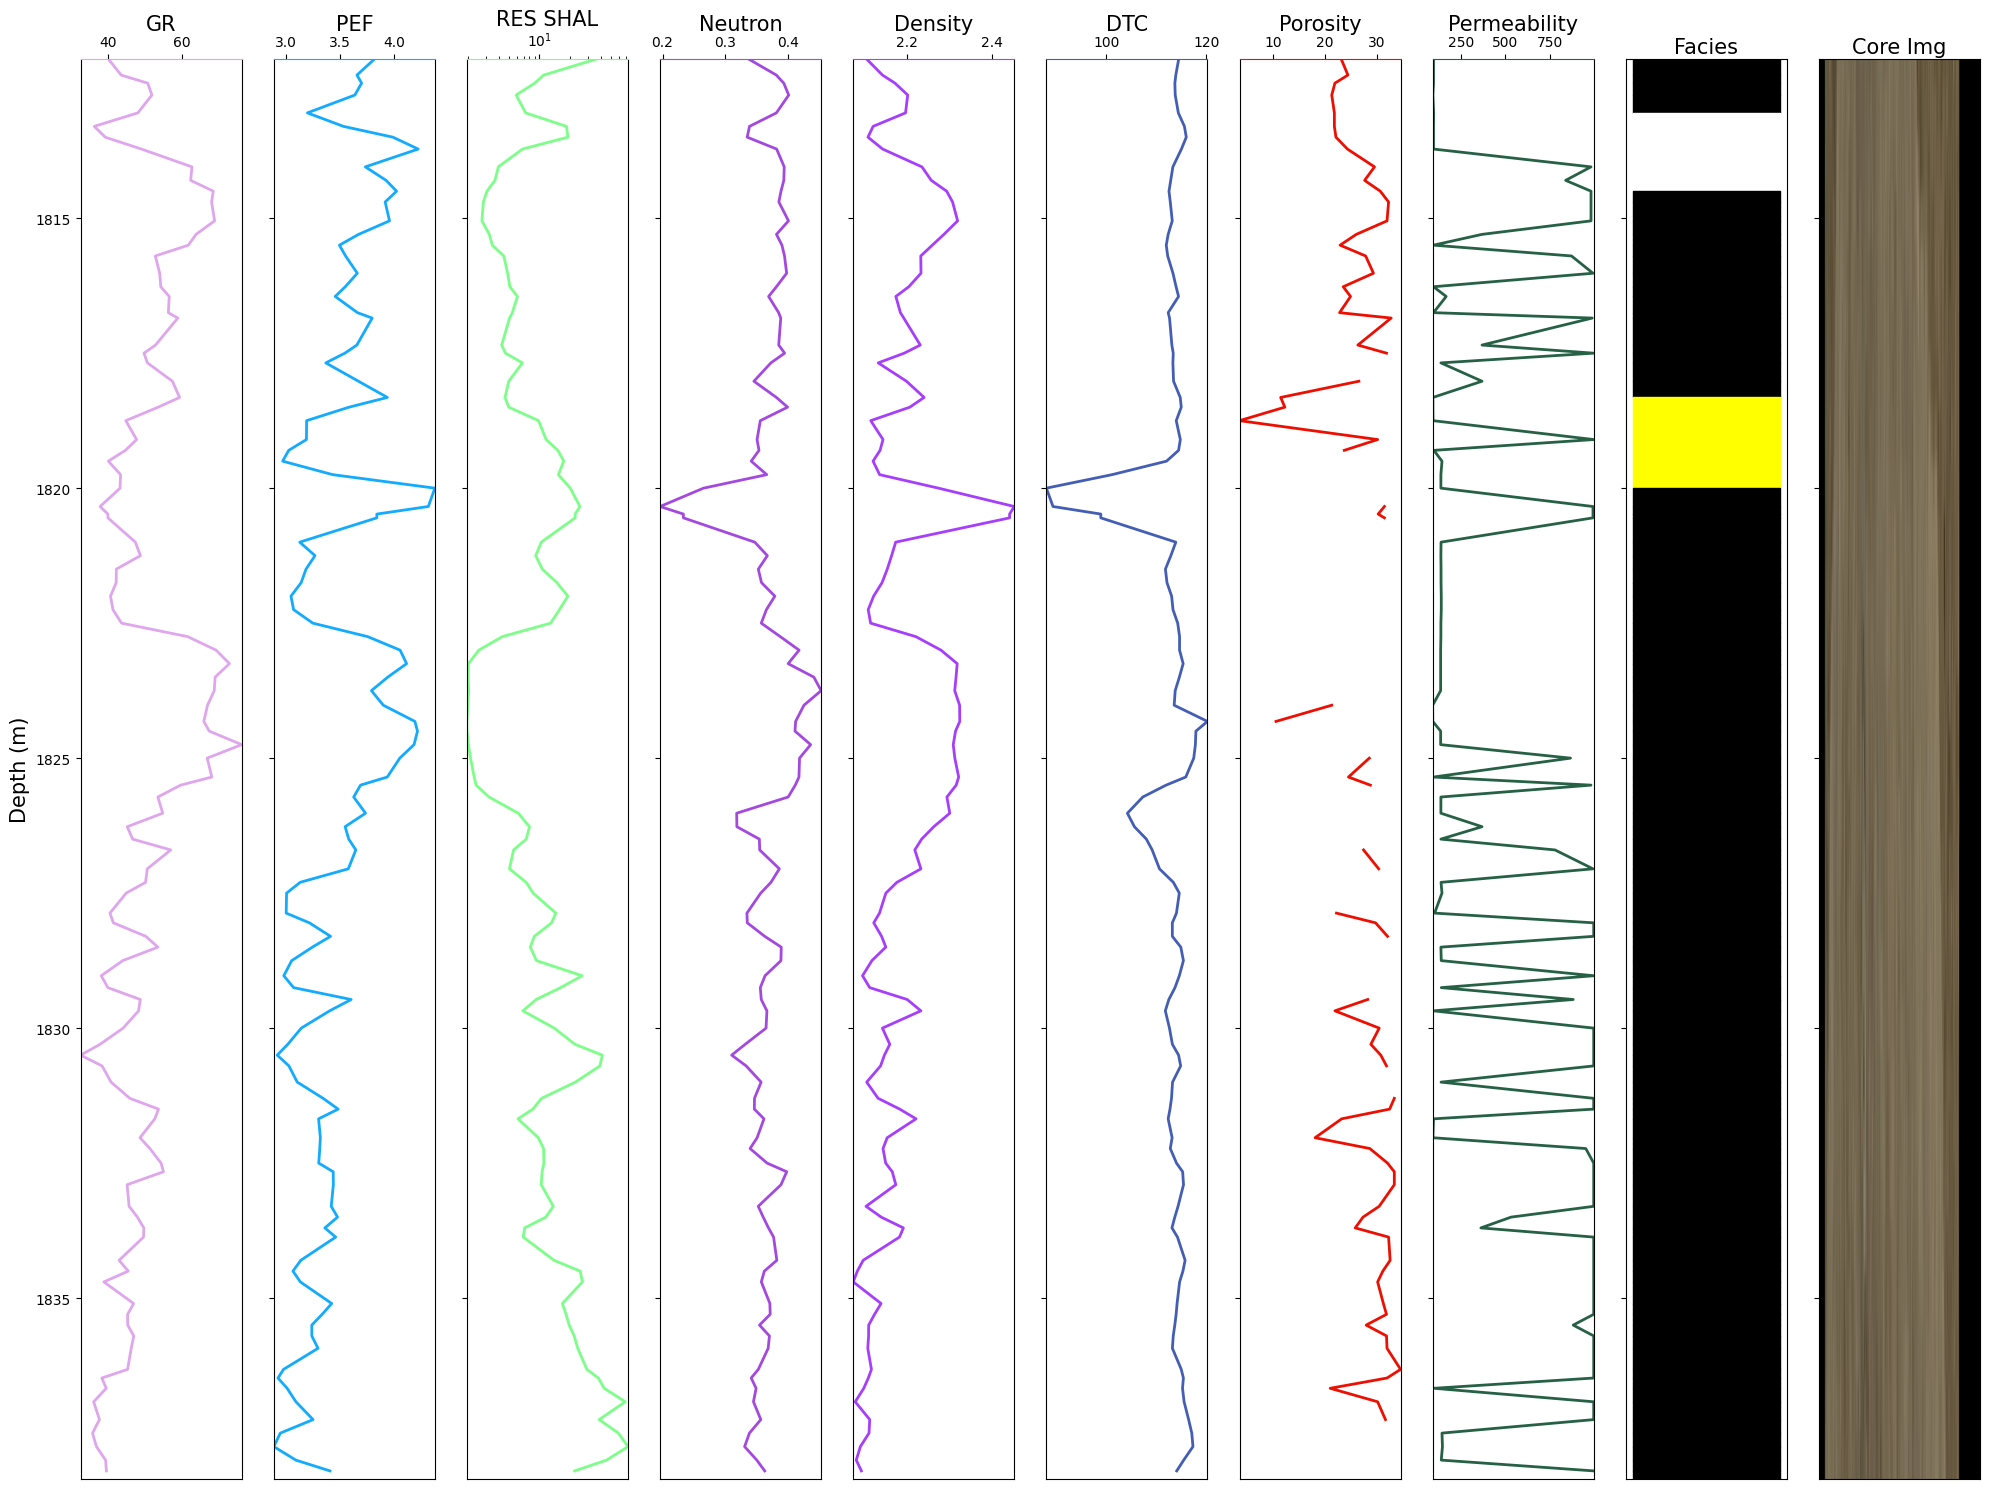

In [12]:
import random
import matplotlib.image as mpimg

# file_path = f'{PARENT_PATH}/Sources/blinded_well/preprocessed/205-21b-3_image.npy'
core_np_data = np.load(f'{PARENT_PATH}/Sources/blinded_well/preprocessed/205-21b-3_image.npy')

facies_colors = {
    'nc'    : '#ffffff',    # white
    's'     : '#ffff00',    # yellow
    'os'    : '#00ff00',    # green
    'bs'    : '#ffffff',    # white
    # 'is'    : '#310A0B',    # shades of brown
    # 'ih'    : '#743A36',    # shades of brown
    # 'sh'    : '#785C33',    # shades of brown
    'is'    : '#000000',    # black
    'ih'    : '#000000',    # black
    'sh'    : '#000000',    # black
    }

# It has to be the following: ['true depth', 'DENS', 'DTC', 'GR', 'NEUT', 'PEF', 'RSHAL', 'POROSITY\n(HELIUM)']
show_titles = {
    'true depth'        : 'Depth',
    'DENS'              : 'Density',
    'DTC'               : 'DTC',
    'GR'                : 'GR',
    'NEUT'              : 'Neutron',
    'PEF'               : 'PEF',
    'RSHAL'             : 'RES SHAL',
    'POROSITY\n(HELIUM)': 'Porosity',
    'Permeability'      : 'Permeability',
    # 'Facies'            : 'Facies',
    # 'Core Img'          : 'Core Img',
    }

show_df = visual_df[['true depth', 'GR', 'PEF', 'RSHAL', 'NEUT', 'DENS', 'DTC', 'POROSITY\n(HELIUM)', 'Permeability', 'Facies']]

def GetRandomColor():
    '''
    Get a random color.
    '''
    r = lambda: random.randint(0,255)
    return '#%02X%02X%02X' % (r(),r(),r())

def Plot_Data(log_df: pd.DataFrame, ylim:[None,list]=None):
    '''
    Plot simple well log data.
    '''
    depth_list = log_df['true depth']

    # Initiate the figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=len(log_df.columns), figsize=(20, 15), sharey=True)

    # Plot the well logs
    for i in range(len(log_df.columns)):

        # Set y axis title
        if i == 0: 
            ax[i].set_ylabel('Depth (m)',fontsize=15)
        
        # Plot Core in the last track
        if i+1 == len(log_df.columns):
            ax[i].imshow(core_np_data, aspect='auto')
            
            ax[i].set_xlabel('Core Img',fontsize=15)
            ax[i].xaxis.set_ticks_position("top")
            ax[i].xaxis.set_label_position("top")
            ax[i].set_xticks([])
            ax[i].spines['top'].set_edgecolor('#000000')
            continue
        
        # Get Parameters
        column_name = log_df.columns[i+1]

        if column_name == 'Facies':

            # Plot the facies
            for d in range(len(facies_df['Start Depth'])):
                start_depth = facies_df['Start Depth'][d]
                end_depth   = facies_df['End Depth'][d]
                facies_class= facies_df['Predicted Class'][d]
                color       = facies_colors[facies_class]
                ax[i].fill_betweenx([start_depth, end_depth], 0, 1, color=color)

            # X Axis
            ax[i].set_xlabel('Facies',fontsize=15)
            ax[i].xaxis.set_ticks_position("top")
            ax[i].xaxis.set_label_position("top")
            ax[i].set_xticks([])
            ax[i].spines['top'].set_edgecolor('#000000')

            continue
        
        else:
            # Get random color
            random_color = GetRandomColor()

            # Plot the log
            ax[i].plot(log_df[column_name], depth_list, '-', color=random_color,linewidth=2)

            # X Axis
            ax[i].set_xlabel(show_titles[column_name],fontsize=15)
            ax[i].set_xlim(log_df[column_name].min(),log_df[column_name].max())
            ax[i].xaxis.set_ticks_position("top")
            ax[i].xaxis.set_label_position("top")
            ax[i].spines['top'].set_edgecolor(random_color)

            # Custom Setting
            if column_name == 'RSHAL': ax[i].set_xscale('log')
    
    # Y Axis
    if ylim != None:    
        ax[i].set_ylim(ylim[0],ylim[1])
        # ax[i].set_yticks([ylim[0],ylim[1]])
    else:               
        ax[i].set_ylim(depth_list.min(),depth_list.max())
        ax[i].set_yticks([depth_list.min(),depth_list.max()])
    
    ax[i].invert_yaxis()
    fig.tight_layout()
    now = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
    fig.savefig(f'{PARENT_PATH}/extras/saved_images/img_{now}.jpg', dpi=300)
    
    return 

# Plot Data
ylim_start = facies_df['Start Depth'].min()
ylim_end   = facies_df['End Depth'].max()
Plot_Data(show_df, ylim=[ylim_start,ylim_end])

/var/folders/cj/7vpbxq116nlcmkbxd8s_svqm0000gn/T/ipykernel_2573/2829857882.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual_df['Permeability']   = perm_predict_df['Permeability'].to_list()
/var/folders/cj/7vpbxq116nlcmkbxd8s_svqm0000gn/T/ipykernel_2573/2829857882.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual_df['Facies']         = [np.nan for i in range(len(visual_df['Permeability']))]   # The values in the list are non-relevant to the plotting.
